# Moving Average Model

* [PennState STAT 510 - Moving Average Models(MA Models)](https://onlinecourses.science.psu.edu/stat510/node/48)

* [Numpy Cookbook 참고](https://books.google.co.kr/books?id=zWHCCAAAQBAJ&pg=PA222&lpg=PA222&dq=numpy+%22moving+average+model%22&source=bl&ots=VWJa0wmEaP&sig=l_pgyToRagDVGnHA_UUo5DO0Ofg&hl=en&sa=X&ved=0ahUKEwig--Ppw4_VAhWIUrwKHWShDQoQ6AEIOTAE#v=onepage&q=numpy%20%22moving%20average%20model%22&f=false)

Moving-average Model MA(q)는 AR(p)와 매우 유사하며 마찬가지로 univariate time series를 모델링 하는데 사용되는 방법중의 하나입니다. <br>
두 모델의 차이점은 MA(q) 모델의 경우 과거의 white noise error를 사용합니다. <br>
<span style="color:red">즉 AR(p)의 경우 과거 p값 만큼의 과거의 lagged variables사용해서 예측을 하는 반면, <br>
MA(q) 모델은 과거의 예측 에러(forecast errors)에서 나온 값을 사용해서 예측을 합니다.</span>

AR Model과 함께 ARMA 그리고 ARIMA 모델의 중요 컴포넌트가 됩니다.<br> 

> Moving Average Model은 Moving Average와 전혀 다릅니다.

## Definition

MA(q) 모델은 noise에 관하여 $ X_t $에 대해 다음과 같이 정의를 하고 있습니다.

$$ X_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} $$

$ \epsilon $ 기호는 error (white noise)로 읽으면 됩니다. (epsilon이 아니라..) <br>
noise 의 (weighted)평균으로 구해지지만 전체 시간을 모두 구하는 것이 아니라, average moving $ t $ 그리고 $ q+1 $ times가 사용됩니다.<br>
time lags를 사용하여 다음과 같이 정의 할 수 있습니다.

$$ X_t = c+ \left(1 + \sum^q_{k=1} \beta_k L^k \right) \epsilon_t $$

## Configuration

In [1]:
LAG = 12

## Import

In [3]:
%pylab inline
import math
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels import api as sm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

from data import get_data

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data

            passenger
1949-01-01      112.0
1949-02-01      118.0
1949-03-01      132.0
1949-04-01      129.0
1949-05-01      121.0


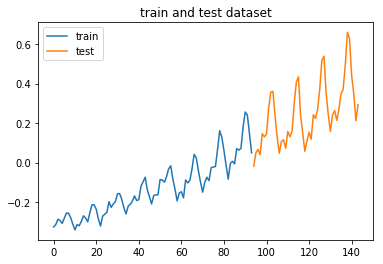

In [4]:
filename = 'dataset/international-airline-passengers.csv'
dataframe, train, test, ts_train, ts_test = get_data(filename, LAG)

print(dataframe.head())
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

In [5]:
from scipy.optimize import leastsq
from statsmodels.regression.linear_model import GLS

class MA(object):
    def __init__(self, lag=5):
        self.lag = lag
        self.w = np.random.rand(lag)
        print(self.w)
        
    def fit(self, x):
        mean = x.mean()
        a, b = leastsq(self.error, self.w, args=(x-mean,) )
        
        gls = GLS(x[1:], x[:-1]).fit()
        print(gls.params)
        return gls
        
        
    def error(self, w, x):
        return w * x[:self.lag].reshape(-1)
        
ma = MA()
gls = ma.fit(train)



[ 0.03579905  0.16367996  0.92868896  0.20454079  0.78493761]
[ 0.9579881]


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   94
Model:                     ARMA(4, 2)   Log Likelihood                 172.898
Method:                       css-mle   S.D. of innovations              0.037
Date:                Tue, 08 Aug 2017   AIC                           -329.796
Time:                        18:28:20   BIC                           -309.449
Sample:                             0   HQIC                          -321.577
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1286      0.083     -1.545      0.126      -0.292       0.034
ar.L1.y        1.9170      0.120     15.967      0.000       1.682       2.152
ar.L2.y       -1.9104      0.229     -8.327      0.0

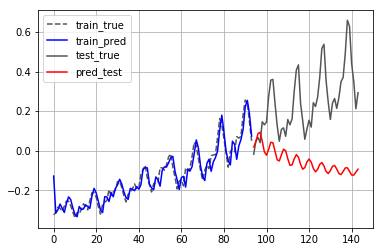

In [7]:
model_arma = ARMA(train, order=(4, 2, 1))
model_arma = model_arma.fit(max_lag=30)
print(model_arma.summary())

pred_train = model_arma.predict(0)
pred_test = model_arma.predict(start=len(train), end=len(train) + len(test)-1)

x_train = np.arange(len(pred_train))
x_test = np.arange(len(pred_train), len(pred_train) + len(pred_test))

plot(x_train, train, linestyle="--", label='train_true', color="#555555")
plot(x_train, pred_train, label='train_pred', color='blue')
plot(x_test, test, label='test_true',  color='#555555')
plot(x_test, pred_test, label='pred_test', color='red')
legend()
grid()

print('Lag:', model_arma.k_ar)
print('Params:', model_arma.params.shape)
print('Train R^2:', r2_score(pred_train, train))
print('Train MSE:', mean_squared_error(pred_train, train))
print('Test  R^2:', r2_score(pred_test, test))
print('Test  MSE:', mean_squared_error(pred_test, test))